In [1]:
import warnings
from argparse import ArgumentParser
import pandas as pd
import pickle

import subprocess
import sys
import os

from datasets import Priv_NAMES as DATASET_NAMES
from datasets import get_private_dataset
from models import get_all_models, get_model
from utils.Server import train
from utils.Toolbox_analysis import create_latent_df, process_latent_df
from utils.Toolbox_visualization import format_latent_dict, load_and_scale_data, combine_latents, plot_latent_heatmap, plot_time_series_and_latents
warnings.simplefilter(action='ignore', category=FutureWarning)

def parse_args():
    parser = ArgumentParser(description='You Only Need Me', allow_abbrev=False)
    parser.add_argument('--device_id', type=int, default=0, help='The Device Id for Experiment')
    parser.add_argument('--run_simulation', type=bool, default=True, help='The Device Id for Experiment')
    parser.add_argument('--detect_anomalies', type=bool, default=False)
    parser.add_argument('--generate_viz', type=bool, default=True, help='Creates and saves interactive visualizations')


    # Communication - epochs
    parser.add_argument('--communication_epoch', type=int, default=15,
                        help='The Communication Epoch in Federated Learning')
    parser.add_argument('--local_epoch', type=int, default=1, help='The Local Epoch for each Participant')

    # Participants info
    parser.add_argument('--parti_num', type=int, default=None, help='The Number for Participants. If "None" will be setted as the sum of values described in --domain')
    parser.add_argument('--online_ratio', type=float, default=1, help='The Ratio for Online Clients')

    # Data parameter
    parser.add_argument('--dataset', type=str, default='fl_leaks', choices=DATASET_NAMES, help='Which scenario to perform experiments on.')
    parser.add_argument('--experiment_id', type=str, default='Pipeline_Full_medium_E', help='Experiment identifier')
    parser.add_argument('--extra_coments', type=str, default='proto_month_0.2_20', help='Aditional info')
    parser.add_argument('--domains', type=dict, default={
                                                        'Graeme': 5,
                                                        # 'Balerma': 3,
                                                        },
                        help='Domains and respective number of participants.')

    ## Time series preprocessing
    parser.add_argument('--interval_agg', type=int, default=2 * 60 ** 2,
                        help='Agregation interval (seconds) of time series')
    parser.add_argument('--window_size', type=int, default=84, help='Rolling window length')

    # Model (AER) parameters
    parser.add_argument('--input_size', type=int, default=5, help='Number of sensors')  #TODO adaptar
    parser.add_argument('--output_size', type=int, default=5, help='Shape output - dense layer')
    parser.add_argument('--lstm_units', type=int, default=30,
                        help='Number of LSTM units (the latent space will have dimension 2 times bigger')
    

    # Federated parameters
    parser.add_argument('--model', type=str, default='fpl', help='Federated Model name.', choices=get_all_models()) #fedavg

    parser.add_argument('--structure', type=str, default='homogeneity')

    parser.add_argument('--pri_aug', type=str, default='weak',  # weak strong
                        help='Augmentation for Private Data')
    parser.add_argument('--learning_decay', type=bool, default=False, help='The Option for Learning Rate Decay')
    parser.add_argument('--averaging', type=str, default='weight', help='The Option for averaging strategy')

    parser.add_argument('--infoNCET', type=float, default=0.02, help='The InfoNCE temperature')
    parser.add_argument('--T', type=float, default=0.05, help='The Knowledge distillation temperature')
    parser.add_argument('--weight', type=int, default=1, help='The Weigth for the distillation loss')

    args, unknown = parser.parse_known_args()

    if args.parti_num is None:
        args.parti_num = sum(args.domains.values())

    return args

args = parse_args()

In [2]:
agg_int = 2
results_id = f'{args.experiment_id}_{args.communication_epoch}_{args.local_epoch}_{agg_int}_{args.window_size}_{args.extra_coments}'

results_path = f"results/results_{results_id}.pkl"
latent_path = f"results/latent_{results_id}.pkl"


with open(results_path, 'rb') as f:
    results = pickle.load(f)

In [3]:
results['Baseline']['model'].local_history.keys()

dict_keys([0, 1, 2, 3, 4])

In [4]:
len(results['Baseline']['model'].global_history[0][0])

1

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import umap
import numpy as np
import pandas as pd


def flatten_prototypes(local_history):
    """Flatten local_history into a DataFrame with prototype features as columns."""
    records = []

    for epoch, clients in local_history.items():
        for client_id, client_data in enumerate(clients):
            for label, prototype in client_data.items():
                prototype = np.array(prototype)
                record = {
                    'epoch': epoch,
                    'client_id': client_id,
                    'label': label,
                }
                for i, val in enumerate(prototype):
                    record[f'feature_{i}'] = val
                records.append(record)

    df = pd.DataFrame(records)
    return df


def normalize_by_epoch(df, feature_cols):
    """
    Normalize prototype features using MinMaxScaler separately for each epoch.
    
    Returns:
    - df_normalized: DataFrame with normalized features
    - scalers_by_epoch: dict of epoch -> fitted MinMaxScaler
    """
    scalers_by_epoch = {}
    df_list = []

    for epoch, group in df.groupby("epoch"):
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(group[feature_cols])
        scaled_df = group.copy()
        scaled_df[feature_cols] = scaled_features
        df_list.append(scaled_df)
        scalers_by_epoch[epoch] = scaler

    df_normalized = pd.concat(df_list, ignore_index=True)
    return df_normalized, scalers_by_epoch


def reduce_dims(X, method=None, n_components=2, umap_neighbors=50, umap_min_dist=0.95):
    """
    Applies PCA and UMAP to the input data.

    Returns:
    - X_pca: PCA-reduced data
    - X_umap: UMAP-reduced data
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    if method == 'PCA':
        return X_pca, None

    reducer = umap.UMAP(n_components=n_components, n_neighbors=umap_neighbors, min_dist=umap_min_dist)
    X_umap = reducer.fit_transform(X)

    if method == 'UMAP':
        return None, X_umap

    return X_pca, X_umap


def process_prototypes(local_history, method=None):
    """
    Full pipeline:
    - Flatten
    - Normalize (MinMax) per epoch
    - Dimensionality reduction

    Returns:
    - df_final: DataFrame with reduced dimensions
    - scalers_by_epoch: dict of epoch -> MinMaxScaler
    """
    df = flatten_prototypes(local_history)
    feature_cols = [col for col in df.columns if col.startswith("feature_")]

    # MinMax scale per epoch
    df_normalized, scalers_by_epoch = normalize_by_epoch(df, feature_cols)

    # Dimensionality reduction
    X = df_normalized[feature_cols].values
    X_pca, X_umap = reduce_dims(X, method=method)

    # Append to DataFrame
    if X_pca is not None:
        df_normalized[['pca_0', 'pca_1']] = X_pca
    if X_umap is not None:
        df_normalized[['umap_0', 'umap_1']] = X_umap

    return df_normalized, scalers_by_epoch

In [6]:
local_history = results['Baseline']['model'].local_history
df_final, scalers_by_epoch = process_prototypes(local_history, method=None)
df_final

epoch  client_id  label  feature_0  feature_1  feature_2  feature_3  \
0        0          0      1   0.016483   0.386177   0.961714   0.913835   
1        0          0      0   0.004098   0.357055   0.956883   0.906982   
2        0          0      3   0.054670   0.316262   0.936130   0.877265   
3        0          0      4   0.066875   0.270043   0.919548   0.884670   
4        0          0      7   0.004958   0.371373   0.962833   0.871402   
..     ...        ...    ...        ...        ...        ...        ...   
895      4         14      5   0.923444   0.525189   0.089044   0.021165   
896      4         14      1   0.938419   0.500076   0.007015   0.115933   
897      4         14      9   0.832481   0.412304   0.075912   0.082469   
898      4         14      4   0.940581   0.539197   0.023790   0.020676   
899      4         14     11   0.881681   0.512545   0.090748   0.052044   

     feature_4  feature_5  feature_6  ...  feature_34  feature_35  feature_36  \
0     0.639351   0.898241   0.281922  ...    0.472948    0.038026    0.940583   
1     0.641096   0.913612   0.274567  ...    0.630028    0.139481    0.902728   
2     0.613616   0.955111   0.184332  ...    0.634031    0.092920    0.899419   
3     0.608431   0.880725   0.153627  ...    0.579281    0.000000    0.905898   
4     0.630457   0.920622   0.207688  ...    0.589996    0.058486    0.885502   
..         ...        ...        ...  ...         ...         ...         ...   
895   0.714607   0.289302   0.651492  ...    0.726681    0.433997    0.534887   
896   0.675949   0.203732   0.507037  ...    0.899800    1.000000    0.636855   
897   0.679854   0.212268   0.333318  ...    0.600877    0.177524    0.616091   
898   0.789722   0.383676   0.555003  ...    0.803506    0.596844    0.487456   
899   0.724824   0.347448   0.552557  ...    0.885456    0.635686    0.419875   

     feature_37  feature_38  feature_39     pca_0     pca_1     umap_0  \
0      0.775556    0.864245    0.077453 -1.569425  1.245150 -24.339499   
1      0.857030    1.000000    0.138704 -1.522670  1.274165 -23.680258   
2      0.890690    0.959797    0.070700 -1.581662  1.242895 -23.878620   
3      0.910557    0.877544    0.000000 -1.582931  1.296598 -24.060171   
4      0.882795    0.927516    0.094552 -1.574258  1.267476 -23.913897   
..          ...         ...         ...       ...       ...        ...   
895    0.245415    0.234693    0.782555  1.193587  0.439759 -40.523952   
896    0.171555    0.625299    0.830583  1.369029  0.403739 -40.359032   
897    0.299089    0.149533    0.985003  0.895608  0.691483 -39.982342   
898    0.193748    0.356705    0.738744  1.304901  0.370928 -40.829620   
899    0.080243    0.406720    0.574667  1.381072  0.448309 -40.316868   

        umap_1  
0    12.918077  
1    13.849057  
2    13.672853  
3    13.596967  
4    13.259624  
..         ...  
895  16.166288  
896  17.758318  
897  15.440806  
898  16.809420  
899  17.524067  

[900 rows x 47 columns]

In [7]:
import altair as alt

def plot_prototypes(df, method='umap'):
    """
    Plots reduced prototype data using Altair with interactive filters for epoch and label.

    Parameters:
    - df: DataFrame from process_prototypes
    - method: 'umap' or 'pca'
    """
    assert method in ['umap', 'pca'], "method must be 'umap' or 'pca'"
    
    x_col = f'{method}_0'
    y_col = f'{method}_1'

    # Epoch dropdown selector
    epoch_selector = alt.binding_select(options=sorted(df['epoch'].unique()), name="Epoch")
    epoch_selection = alt.selection_point(
        fields=['epoch'],
        bind=epoch_selector
    )

    # Label dropdown selector
    label_selector = alt.binding_select(options=sorted(df['label'].unique()), name="Label")
    label_selection = alt.selection_point(
        fields=['label'],
        bind=label_selector
    )

    # Base chart
    chart = alt.Chart(df).mark_point(filled=True, size=100).encode(
        x=alt.X(x_col, title=f"{method.upper()} 1"),
        y=alt.Y(y_col, title=f"{method.upper()} 2"),
        color=alt.Color('label:N', title='Label'),
        shape=alt.Shape('client_id:N', title='Client ID'),
        tooltip=['epoch', 'client_id', 'label']
    ).add_params(
        epoch_selection,
        label_selection
    ).transform_filter(
        epoch_selection
    ).transform_filter(
        label_selection
    ).properties(
        width=600,
        height=400,
        title=f'{method.upper()} Projection of Prototypes (Interactive)'
    ).interactive()  # enables zoom and pan

    return chart

In [8]:
from itertools import combinations

def compute_distance_lines(df, x_col, y_col):
    """
    Compute pairwise distances between points,
    grouped by epoch and label (filtered view).
    """
    lines = []

    for (epoch, label), group in df.groupby(['epoch', 'label']):
        coords = group[[x_col, y_col]].values
        indices = group.index.values

        for (i, j) in combinations(range(len(coords)), 2):
            x1, y1 = coords[i]
            x2, y2 = coords[j]
            dist = np.linalg.norm(coords[i] - coords[j])
            lines.append({
                'epoch': epoch,
                'label': label,
                'x1': x1, 'y1': y1,
                'x2': x2, 'y2': y2,
                'distance': dist
            })

    return pd.DataFrame(lines)
    
def plot_prototypes_with_distances(df, method='umap'):
    """
    Interactive Altair plot with:
    - Epoch slider
    - Label dropdown
    - Distance lines only within selected epoch and label
    """
    assert method in ['umap', 'pca'], "method must be 'umap' or 'pca'"
    x_col = f'{method}_0'
    y_col = f'{method}_1'

    # Precompute distances grouped by epoch + label
    df_lines = compute_distance_lines(df, x_col, y_col)

    # Interactive widgets
    epoch_slider = alt.binding_range(min=int(df['epoch'].min()),
                                     max=int(df['epoch'].max()),
                                     step=1, name="Epoch")
    epoch_selection = alt.selection_point(fields=['epoch'], bind=epoch_slider)

    label_selector = alt.binding_range(min=int(df['label'].min()),
                                     max=int(df['label'].max()),
                                     step=1, name="Label")
    label_selection = alt.selection_point(fields=['label'], bind=label_selector)

    # Distance lines
    line_chart = alt.Chart(df_lines).mark_line(opacity=0.2).encode(
        x='x1:Q', y='y1:Q',
        x2='x2:Q', y2='y2:Q',
        strokeWidth=alt.StrokeWidth('distance:Q', 
            # scale=alt.Scale(domain=[0, df_lines['distance'].max()], range=[0.5, 5])
                                   ),
        tooltip=['distance']
    ).transform_filter(
        epoch_selection
    ).transform_filter(
        label_selection
    )

    # Prototype scatter points
    point_chart = alt.Chart(df).mark_point(filled=True, size=100).encode(
        x=alt.X(x_col, title=f"{method.upper()} 1"),
        y=alt.Y(y_col, title=f"{method.upper()} 2"),
        color=alt.Color('label:N', title='Label'),
        shape=alt.Shape('client_id:N', title='Client ID'),
        tooltip=['epoch', 'client_id', 'label']
    ).transform_filter(
        epoch_selection
    ).transform_filter(
        label_selection
    )

    # Combine
    chart = (line_chart + point_chart).add_params(
        epoch_selection,
        label_selection
    ).properties(
        width=300,
        height=300,
        title=f'{method.upper()} Projection with Pairwise Distances (Filtered)'
    ).interactive()

    return chart


In [9]:
# latent_path = f"results/latent_Pipeline_Full_medium_E_15_1_2_84_proto_month.pkl"

with open(latent_path, 'rb') as f:
    latent = pickle.load(f)

latent_path

'results/latent_Pipeline_Full_medium_E_15_1_2_84_proto_month_0.2_20.pkl'

In [49]:
import numpy as np

aux_proto = []
aux_latent = []

for epoch in list(latent['Baseline'].keys()):
    data = latent['Baseline'][epoch]['latent_space'].copy()
    data['month'] = data['timestamp'].dt.month
    
    data_agg = data.drop(columns=['timestamp', 'week', 'hour'])
    data_agg = data_agg.groupby(['label', 'month']).mean().reset_index()

    feature_cols = [col for col in data.columns if col.startswith('x_')]
    
    x_data = data[feature_cols].values
    x_proto = data_agg[feature_cols].values
    
    X_raw = np.concatenate([x_data, x_proto])
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_raw)
    
    X_pca_scaled, X_umap_scaled = reduce_dims(
        X=X_scaled,
        method=None,
        n_components=2,
        umap_neighbors=50,
        umap_min_dist=0.95
    )

    red_proto = X_pca_scaled[-60:, :]
    
    df_proto = data_agg[['month', 'label']].copy()
    df_proto['pca_0'], df_proto['pca_1'] = red_proto[:,0], red_proto[:,1]
    
    red_proto = X_umap_scaled[-60:, :]
    df_proto['umap_0'], df_proto['umap_1'] = red_proto[:,0], red_proto[:,1]
    
    df_proto['epoch'] = epoch
    df_proto.rename(columns = {'label' : 'client_id', 'month' : 'label'}, inplace = True)

    aux_proto.append(df_proto)


    red_latent = X_pca_scaled[:-60, :]
    df_latent = data[['month', 'label']].copy()
    df_latent['pca_0'], df_latent['pca_1'] = red_latent[:,0], red_latent[:,1]
    
    red_latent = X_umap_scaled[:-60, :]
    df_latent['umap_0'], df_latent['umap_1'] = red_latent[:,0], red_latent[:,1]
    
    df_latent['epoch'] = epoch
    df_latent.rename(columns = {'label' : 'client_id', 'month' : 'label'}, inplace = True)

    aux_latent.append(df_latent)

In [50]:
from itertools import combinations
import numpy as np
import pandas as pd

def compute_distance_lines_with_clients(df, x_col, y_col):
    """
    Compute pairwise distances between clients,
    grouped by epoch and label. Keeps track of client IDs.
    """
    lines = []

    for (epoch, label), group in df.groupby(['epoch', 'label']):
        coords = group[[x_col, y_col]].values
        client_ids = group['client_id'].values

        for (i, j) in combinations(range(len(coords)), 2):
            x1, y1 = coords[i]
            x2, y2 = coords[j]
            dist = np.linalg.norm(coords[i] - coords[j])
            lines.append({
                'epoch': epoch,
                'label': label,
                'client_id': client_ids[i],
                'client2': client_ids[j],
                'distance': dist,
                'x1': x1, 'y1': y1,
                'x2': x2, 'y2': y2,
            })

    return pd.DataFrame(lines)



def plot_prototypes_with_distances(df, method='umap'):
    """
    Interactive Altair plot with:
    - Epoch slider
    - Label dropdown
    - Distance lines only within selected epoch and label
    """
    assert method in ['umap', 'pca'], "method must be 'umap' or 'pca'"
    x_col = f'{method}_0'
    y_col = f'{method}_1'

    # Precompute distances grouped by epoch + label
    df_lines = compute_distance_lines_with_clients(df, x_col, y_col)
    aux = [df_lines]
    for client in df_plot['client_id'].unique().tolist():
        df_lines_aux = df_lines[df_lines['client2'] == client].copy()
        df_lines_aux.rename(columns = {'client_id' : 'client2', 'client2' : 'client_id'}, inplace = True)
        df_lines_aux = df_lines_aux[df_lines.columns]
        aux.append(df_lines_aux)
    df_lines = pd.concat(aux)

    # Interactive widgets
    epoch_slider = alt.binding_range(min=int(df['epoch'].min()),
                                     max=int(df['epoch'].max()),
                                     step=1, name="Epoch")
    epoch_selection = alt.selection_point(fields=['epoch'], bind=epoch_slider, value = df['epoch'].min())

    label_options = [None] + sorted(df['label'].unique().tolist())
    label_selection = alt.selection_point(fields=['label'], bind=alt.binding_select(options=label_options, name = 'Labels: '), value = df['label'].min())

    # Distance lines
    line_chart = alt.Chart(df_lines).mark_line(opacity=0.2).encode(
        x='x1:Q', y='y1:Q',
        x2='x2:Q', y2='y2:Q',
        strokeWidth=alt.StrokeWidth('distance:Q', 
            # scale=alt.Scale(domain=[0, df_lines['distance'].max()], range=[0.5, 5])
                                   ),
        tooltip=['distance']
    ).transform_filter(
        epoch_selection
    ).transform_filter(
        label_selection
    )

    # Prototype scatter points
    point_chart = alt.Chart(df).mark_point(filled=True, size=100).encode(
        x=alt.X(x_col, title=f"{method.upper()} 1"),
        y=alt.Y(y_col, title=f"{method.upper()} 2"),
        color=alt.Color('label:N', title='Label'),
        shape=alt.Shape('client_id:N', title='Client ID'),
        tooltip=['epoch', 'client_id', 'label']
    ).transform_filter(
        epoch_selection
    ).transform_filter(
        label_selection
    )

    # Combine
    chart = (line_chart + point_chart).add_params(
        epoch_selection,
        label_selection
    ).properties(
        width=300,
        height=300,
        title=f'{method.upper()} Projection with Pairwise Distances (Filtered)'
    ).interactive()

        
            
    # New client selector
    client_selector = alt.binding_select(options=sorted(df['client_id'].unique()), name="Client")
    client_selection = alt.selection_point(fields=['client_id'], bind=client_selector, value = 'District_A')
        
    # Line plot over labels
    line_summary_chart = alt.Chart(df_lines).mark_line(point=True).encode(
        x=alt.X('label:O', title='Label'),
        y=alt.Y('distance:Q', title='Distance to Selected Client'),
        color=alt.Color('client2:N', title='Other Client', legend=None),
        tooltip=['label', 'distance', 'client2']
    ).add_params(
        client_selection, epoch_selection
    ).transform_filter(
        client_selection & epoch_selection
    ).properties(
        width=300,
        height=200,
        title='Distance to Selected Client across Labels (Selected Epoch)'
    )
    
    return chart | line_summary_chart

In [51]:
df_plot = pd.concat(aux_proto)
df_plot.reset_index(drop = True, inplace = True)
df_plot['client_id'] = df_plot['client_id'].str.split('__').str[1]

plot = plot_prototypes_with_distances(df_plot, method='pca')
plot

alt.HConcatChart(...)

In [13]:
# plot.save('results/imgs/proto_base_50_0.2_20.html')

In [55]:
df_latent = pd.concat(aux_latent)
df_latent.reset_index(drop = True, inplace = True)
df_latent['client_id'] = df_latent['client_id'].str.split('__').str[1]

df_latent.head()

label   client_id     pca_0     pca_1    umap_0    umap_1  epoch
0      1  District_A  2.082505  0.766713  7.183854 -0.579172      0
1      1  District_A  2.137537  0.724117  6.759345 -2.611201      0
2      1  District_A  2.067870  0.720457  7.050564 -2.617492      0
3      1  District_A  2.106743  0.704310  6.507311 -2.150716      0
4      1  District_A  2.067101  0.787773  7.373772 -0.534201      0

In [59]:
qwe = df_latent[(df_latent['client_id'] == 'District_A') & (df_latent['epoch'] == 14)]
qwe[qwe['label'] == 1]

label   client_id     pca_0     pca_1     umap_0    umap_1  epoch
296590      1  District_A  1.503460  0.435187  15.467507  5.382832     14
296591      1  District_A  1.434137  0.440253  18.347099  3.061473     14
296592      1  District_A  1.481417  0.467160  16.580881  5.066615     14
296593      1  District_A  1.421833  0.442343  16.872328  4.796399     14
296594      1  District_A  1.336243  0.393122  16.670404  2.635969     14
...       ...         ...       ...       ...        ...       ...    ...
296957      1  District_A  1.326131  0.342476  16.680695  3.461266     14
296958      1  District_A  1.369351  0.319969  16.192074  4.570084     14
296959      1  District_A  1.384687  0.322450  15.630188  5.146277     14
296960      1  District_A  1.351483  0.275818  17.165874  4.745259     14
296961      1  District_A  1.340389  0.377354  14.977588  4.302257     14

[372 rows x 7 columns]

In [71]:
data = latent['Baseline'][14]['latent_space'].copy()
data['month'] = data['timestamp'].dt.month

feature_cols = [col for col in data.columns if col.startswith('x_')]

x_data = data[feature_cols].values

scaler = MinMaxScaler()
x_scl = scaler.fit_transform(x_data)

df_scl = data[['month', 'label']].copy()

for i, feat in enumerate(feature_cols):
    df_scl[feat] = x_scl[:, i]
    
df_scl.rename(columns = {'label' : 'client_id', 'month' : 'label'}, inplace = True)
df_scl['client_id'] = df_scl['client_id'].str.split('__').str[1]

df_scl.head()

label   client_id       x_0       x_1       x_2       x_3       x_4  \
0      1  District_A  0.346425  0.528547  0.345281  0.252769  0.271071   
1      1  District_A  0.922042  0.651472  0.149660  0.476432  0.346260   
2      1  District_A  0.635304  0.669512  0.166813  0.389892  0.335044   
3      1  District_A  0.571917  0.565591  0.121388  0.410255  0.339917   
4      1  District_A  0.807926  0.818625  0.265170  0.483622  0.327533   

        x_5       x_6       x_7  ...      x_30      x_31      x_32      x_33  \
0  0.525118  0.952367  0.338785  ...  0.885777  0.921251  0.812938  0.327208   
1  0.640628  0.950953  0.714316  ...  0.835812  0.899418  0.731884  0.419002   
2  0.537252  0.961885  0.556152  ...  0.925562  0.921445  0.878388  0.304070   
3  0.510366  0.960618  0.521018  ...  0.821653  0.915417  0.721961  0.342967   
4  0.658651  0.925792  0.878739  ...  0.872217  0.892367  0.725499  0.586397   

       x_34      x_35      x_36      x_37      x_38      x_39  
0  0.960554  0.727612  0.189739  0.134118  0.666391  0.730167  
1  0.954092  0.717899  0.116916  0.096327  0.666886  0.819726  
2  0.968055  0.726039  0.285131  0.155305  0.701536  0.666540  
3  0.942704  0.711485  0.204918  0.107423  0.702711  0.750149  
4  0.956716  0.645676  0.148854  0.116729  0.646703  0.764141  

[5 rows x 42 columns]

In [93]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import wasserstein_distance, energy_distance
from scipy.linalg import subspace_angles
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


# --- Drift Metrics Functions

def compute_mmd(X, Y, gamma=1.0):
    K = rbf_kernel(X, X, gamma=gamma)
    L = rbf_kernel(Y, Y, gamma=gamma)
    KL = rbf_kernel(X, Y, gamma=gamma)
    return K.mean() + L.mean() - 2 * KL.mean()

def subspace_alignment(X1, X2, n_components=10):
    pca1 = PCA(n_components=n_components).fit(X1)
    pca2 = PCA(n_components=n_components).fit(X2)
    angles = subspace_angles(pca1.components_.T, pca2.components_.T)
    return np.sum(np.cos(angles))

def dtw_client_trajectory(df, client):
    grouped = df[df.client_id == client].sort_values(by="label")
    monthly = grouped.groupby("label")[features].mean().values
    return monthly

def run_dbscan(df_sub):
    db = DBSCAN(eps=0.5, min_samples=5).fit(df_sub[features])
    return db.labels_

def spectral_cluster_latent(df_sub, n_components=2):
    sim = cosine_similarity(df_sub[features])
    embedding = SpectralEmbedding(n_components=n_components, affinity='precomputed')
    X_trans = embedding.fit_transform(sim)
    return X_trans

def compute_mi(df, client_a, client_b, month):
    Xa = df[(df.label == month) & (df.client_id == client_a)][features].values
    Xb = df[(df.label == month) & (df.client_id == client_b)][features].values
    if len(Xa) == 0 or len(Xb) == 0:
        return np.nan
    est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    Xa_d = est.fit_transform(Xa)
    Xb_d = est.fit_transform(Xb)
    mi_scores = [mutual_info_classif(Xa_d, Xb_d[:, i], discrete_features=True).mean() for i in range(Xb_d.shape[1])]
    return np.mean(mi_scores)

def compare_clients_distribution(Xa, Xb):
    mmd_val = compute_mmd(Xa, Xb, gamma=0.5)
    w_dist = np.mean([wasserstein_distance(Xa[:, i], Xb[:, i]) for i in range(Xa.shape[1])])
    e_dist = energy_distance(Xa.flatten(), Xb.flatten())
    return mmd_val, w_dist, e_dist

In [95]:
# --- Setup

df = df_scl.copy()
features = [col for col in df.columns if col.startswith("x_")]
clients = df["client_id"].unique()
months = sorted(df["label"].unique())
target_client = "District_E"

In [97]:
results = []

for month in tqdm(months):
    df_month = df[df.label == month]
    X_target = df_month[df_month.client_id == target_client][features].values
    labels_target = run_dbscan(df_month[df_month.client_id == target_client])
    try:
        spectral_target = spectral_cluster_latent(df_month[df_month.client_id == target_client])
    except Exception:
        spectral_target = None  # fallback

    for other_client in clients:
        if other_client == target_client:
            continue

        X_other = df_month[df_month.client_id == other_client][features].values
        if X_target.size == 0 or X_other.size == 0:
            continue

        # 1. Distribution metrics
        mmd_val, w_dist, e_dist = compare_clients_distribution(X_target, X_other)

        # 2. Subspace alignment
        sa = subspace_alignment(X_target, X_other)

        # 3. DTW over historical latent trajectory
        traj_target = dtw_client_trajectory(df[df.label <= month], target_client)
        traj_other = dtw_client_trajectory(df[df.label <= month], other_client)
        min_len = min(len(traj_target), len(traj_other))
        dtw_val, _ = fastdtw(traj_target[:min_len], traj_other[:min_len], dist=euclidean)

        # 4. Mutual Information
        mi = compute_mi(df, target_client, other_client, month)

        results.append({
            "month": month,
            "target_client": target_client,
            "other_client": other_client,
            "MMD": mmd_val,
            "Wasserstein": w_dist,
            "Energy": e_dist,
            "SubspaceAlignment": sa,
            "DTW": dtw_val,
            "MutualInfo": mi,
        })

df_results = pd.DataFrame(results)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [01:10<00:00,  5.87s/it]


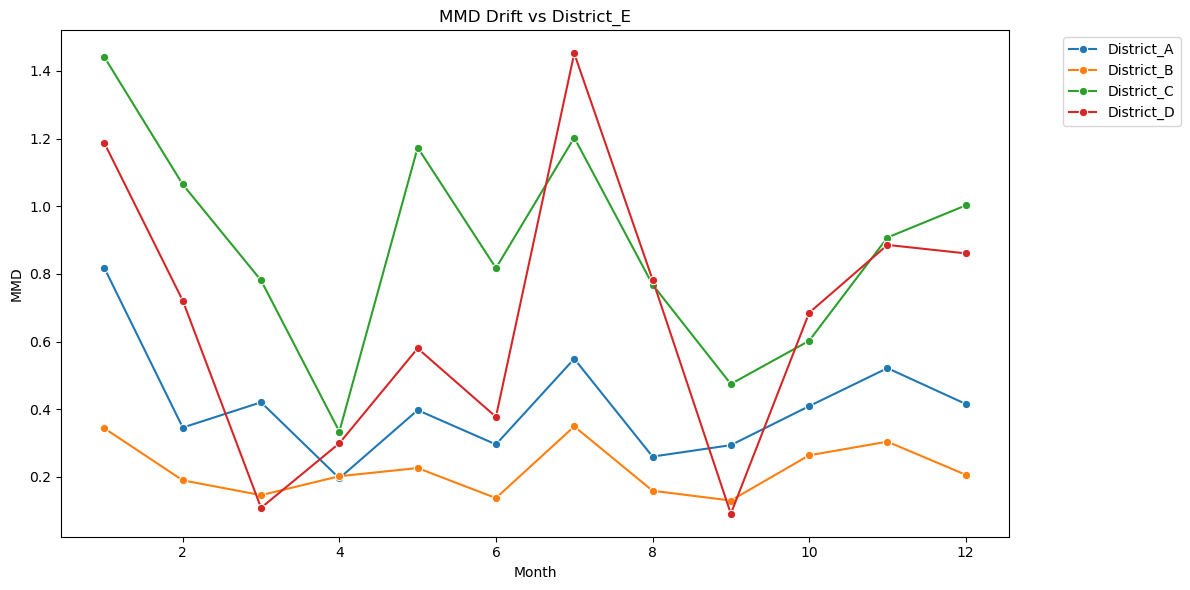

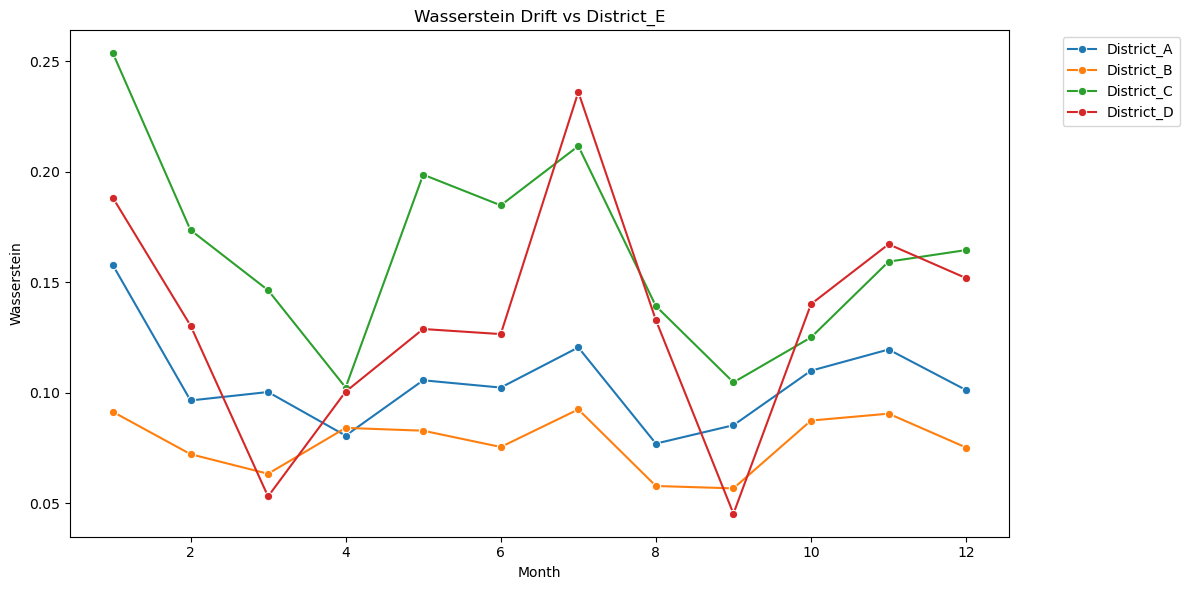

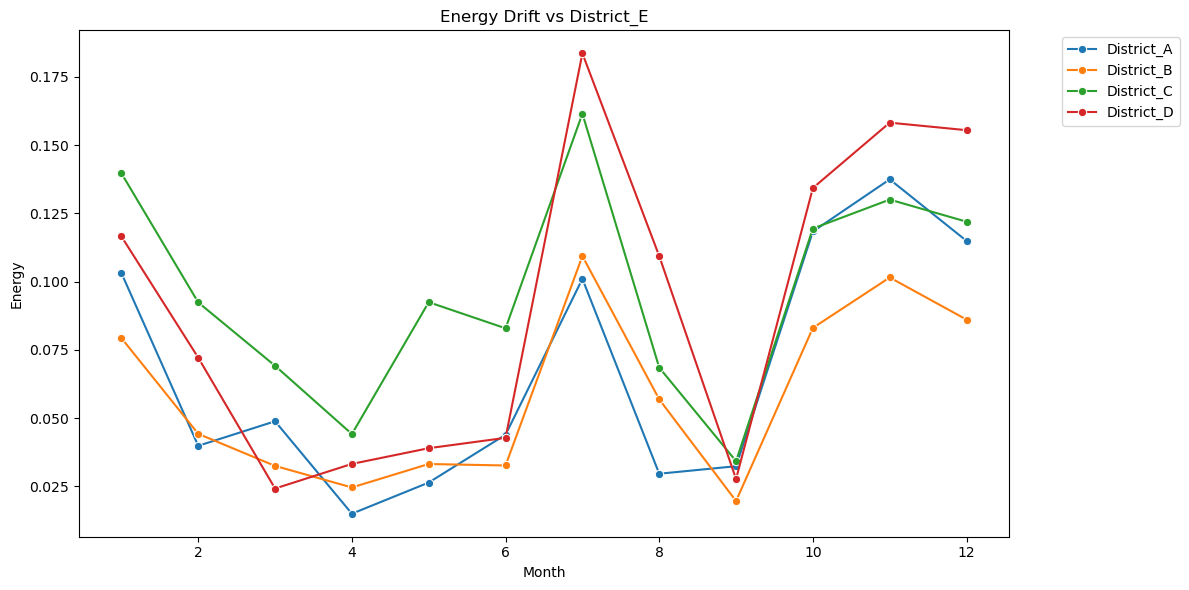

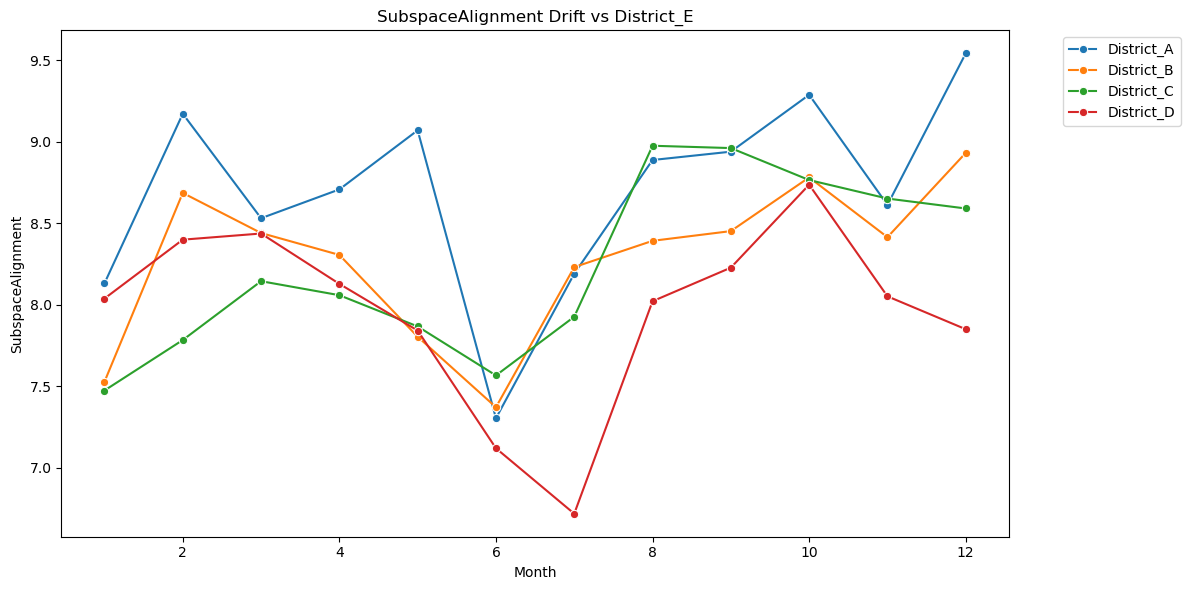

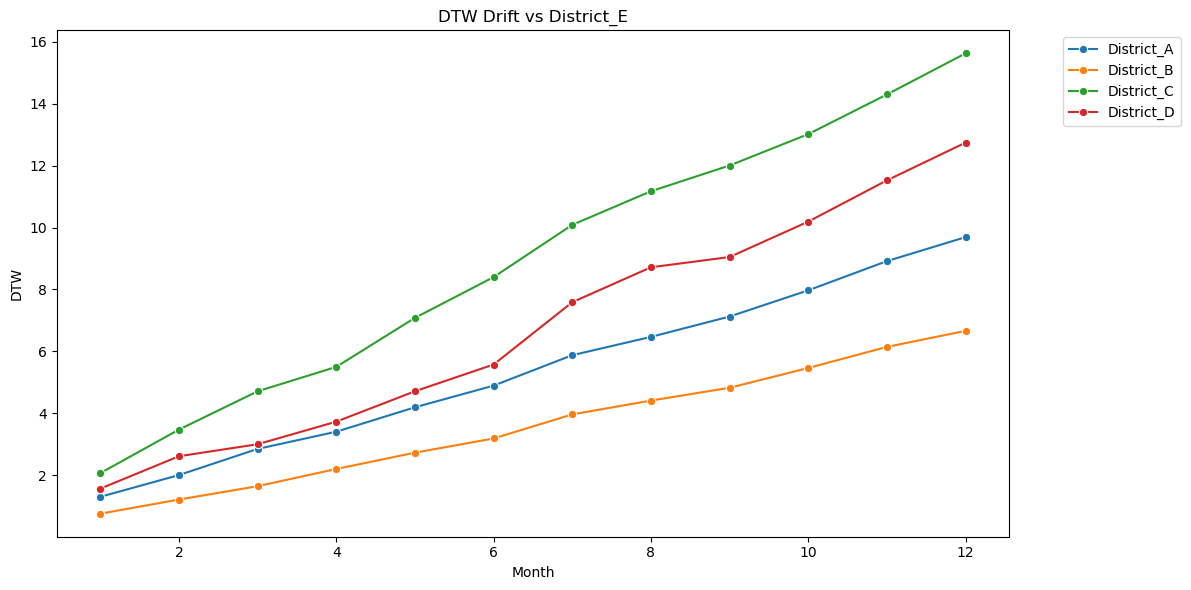

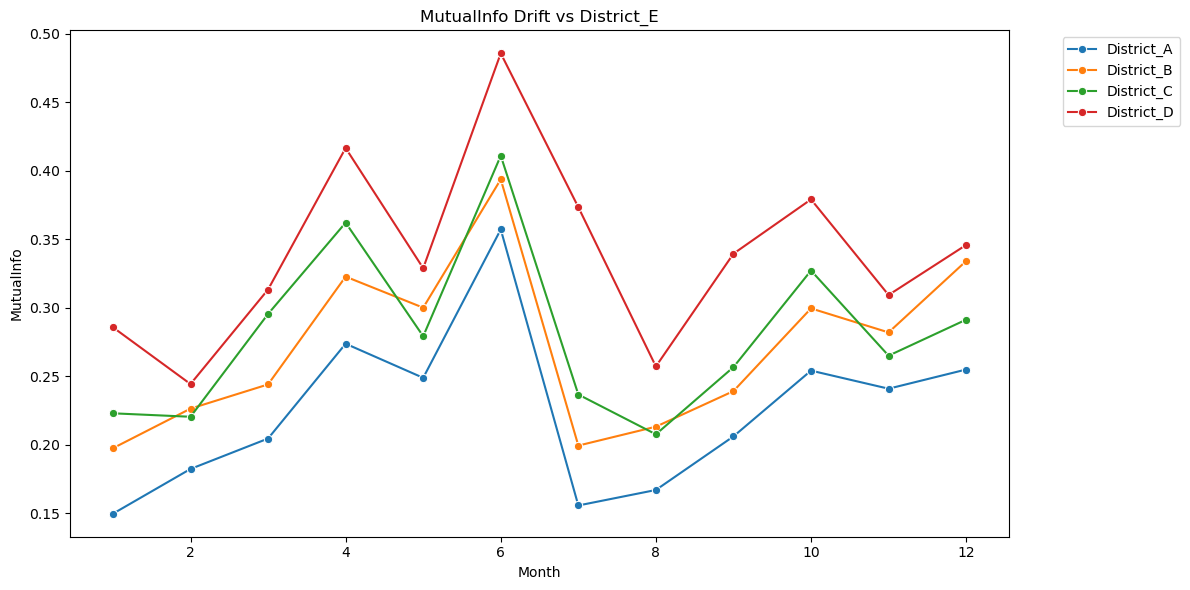

In [99]:
metrics = ["MMD", "Wasserstein", "Energy", "SubspaceAlignment", "DTW", "MutualInfo"]

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_results, x="month", y=metric, hue="other_client", marker="o")
    plt.title(f"{metric} Drift vs {target_client}")
    plt.xlabel("Month")
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [121]:
from umap import UMAP

client_monthly_embeddings = []
spectral_embeddings = []

umap_model = UMAP(n_components=2, random_state=42)
pca_model = PCA(n_components=2)

results = []

for month in tqdm(months):
    df_month = df[df.label == month]
    X_target = df_month[df_month.client_id == target_client][features].values
    labels_target = run_dbscan(df_month[df_month.client_id == target_client])
    try:
        spectral_target = spectral_cluster_latent(df_month[df_month.client_id == target_client])
    except Exception:
        spectral_target = None  # fallback

    for other_client in clients:
        for client in clients:
            client_data = df_month[df_month.client_id == client][features]
            if client_data.empty:
                continue
    
            # Monthly mean latent embedding for PCA/UMAP trajectory
            mean_emb = client_data.mean().values
            client_monthly_embeddings.append({
                "client_id": client,
                "month": month,
                "x": mean_emb
            })
    
            # Save spectral embedding
            try:
                spectral = spectral_cluster_latent(client_data)
                for i, emb in enumerate(spectral):
                    spectral_embeddings.append({
                        "client_id": client,
                        "month": month,
                        "point_id": i,
                        "spectral_x": emb[0],
                        "spectral_y": emb[1]
                    })
            except Exception as e:
                continue  # skip malformed inputs
                
        if other_client == target_client:
            continue

        X_other = df_month[df_month.client_id == other_client][features].values
        if X_target.size == 0 or X_other.size == 0:
            continue

        # 1. Distribution metrics
        mmd_val, w_dist, e_dist = compare_clients_distribution(X_target, X_other)

        # 2. Subspace alignment
        sa = subspace_alignment(X_target, X_other)

        # 3. DTW over historical latent trajectory
        traj_target = dtw_client_trajectory(df[df.label <= month], target_client)
        traj_other = dtw_client_trajectory(df[df.label <= month], other_client)
        min_len = min(len(traj_target), len(traj_other))
        dtw_val, _ = fastdtw(traj_target[:min_len], traj_other[:min_len], dist=euclidean)

        # 4. Mutual Information
        mi = compute_mi(df, target_client, other_client, month)

        results.append({
            "month": month,
            "target_client": target_client,
            "other_client": other_client,
            "MMD": mmd_val,
            "Wasserstein": w_dist,
            "Energy": e_dist,
            "SubspaceAlignment": sa,
            "DTW": dtw_val,
            "MutualInfo": mi,
        })

df_traj = pd.DataFrame(client_monthly_embeddings)
df_spectral = pd.DataFrame(spectral_embeddings)

df_results = pd.DataFrame(results)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [01:15<00:00,  6.33s/it]


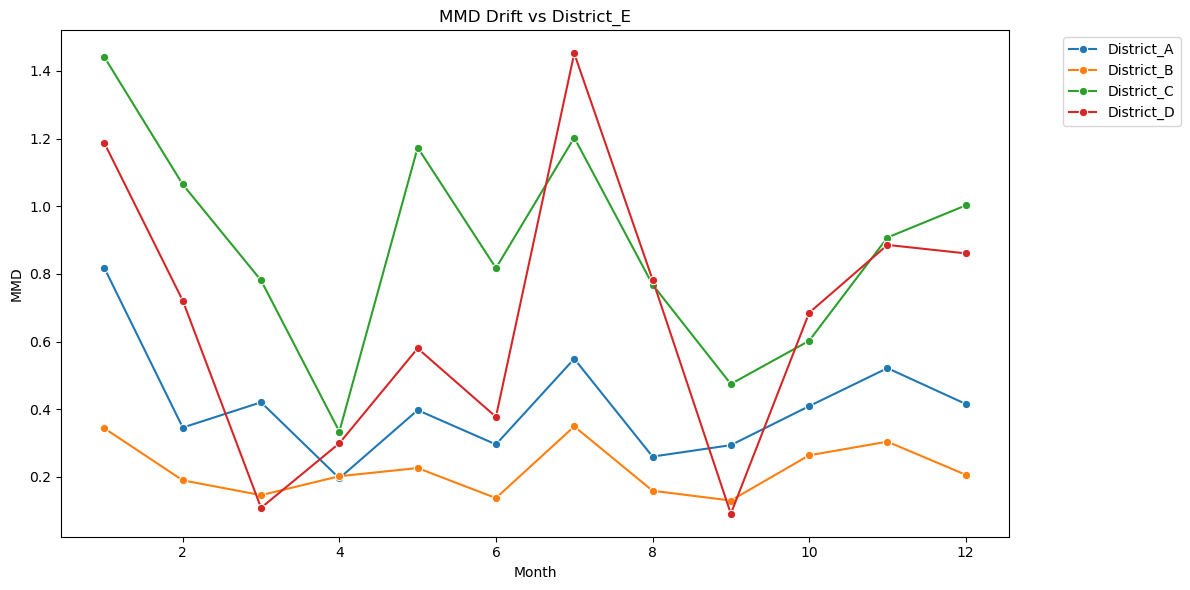

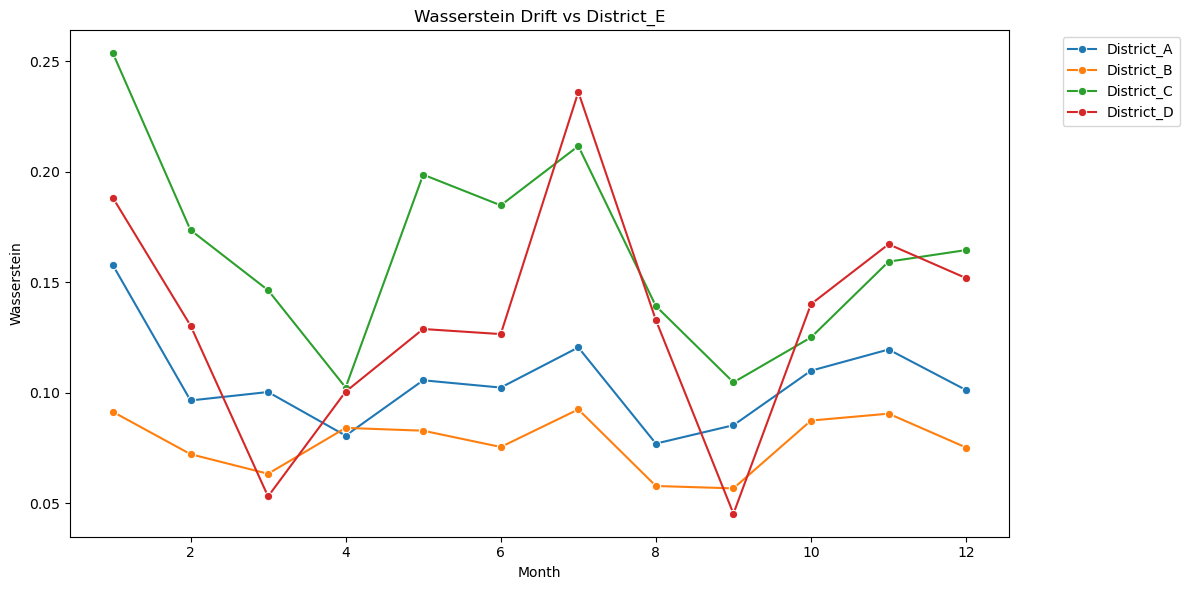

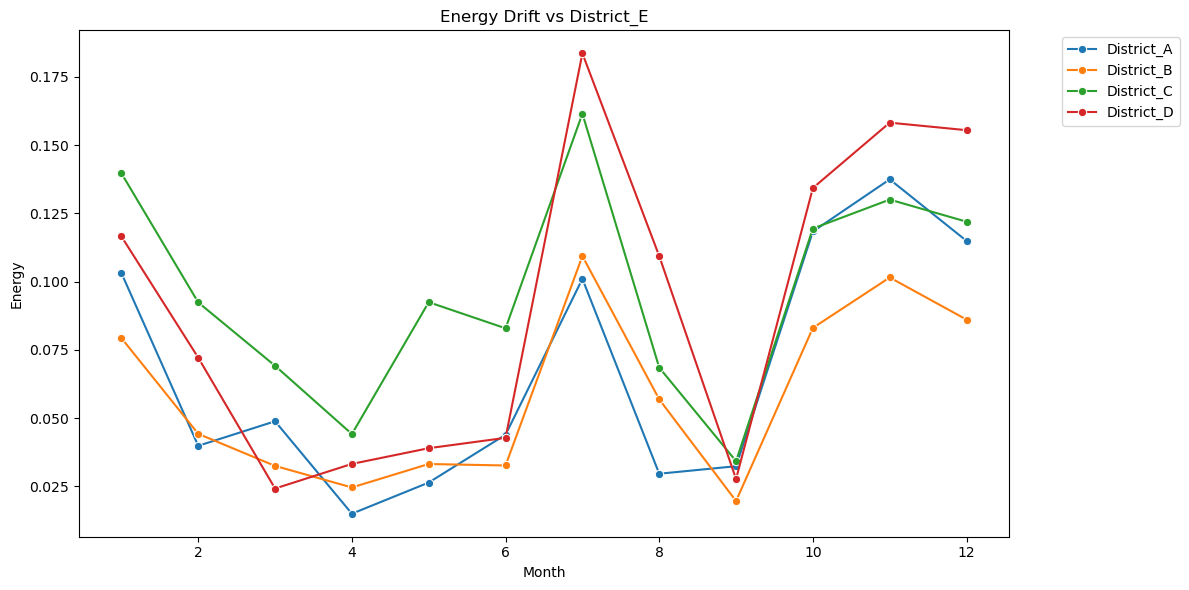

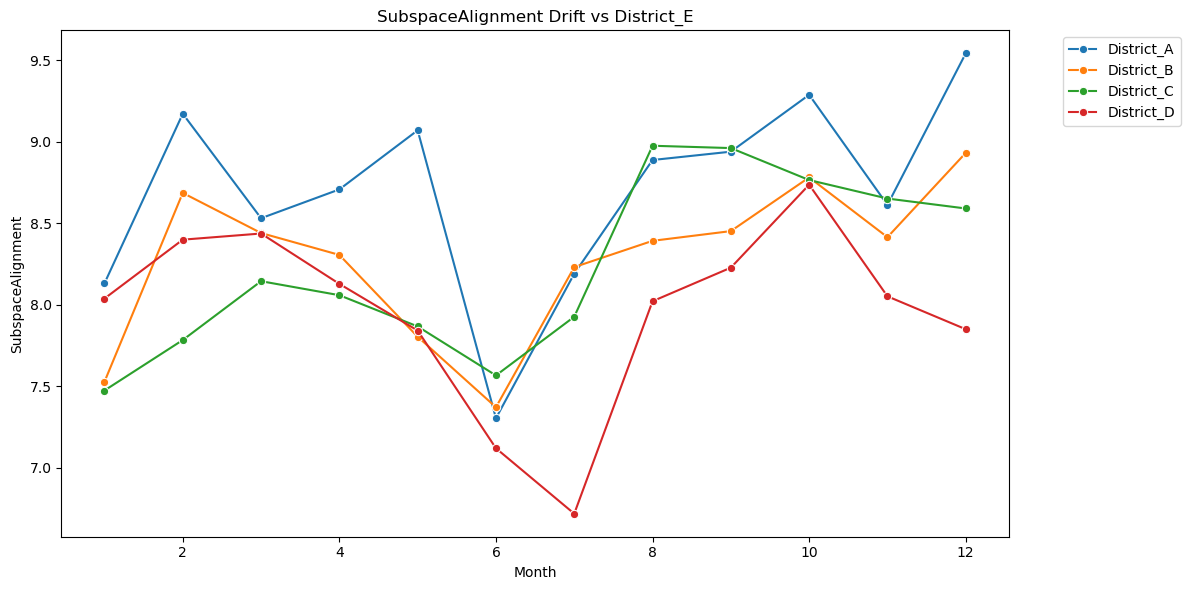

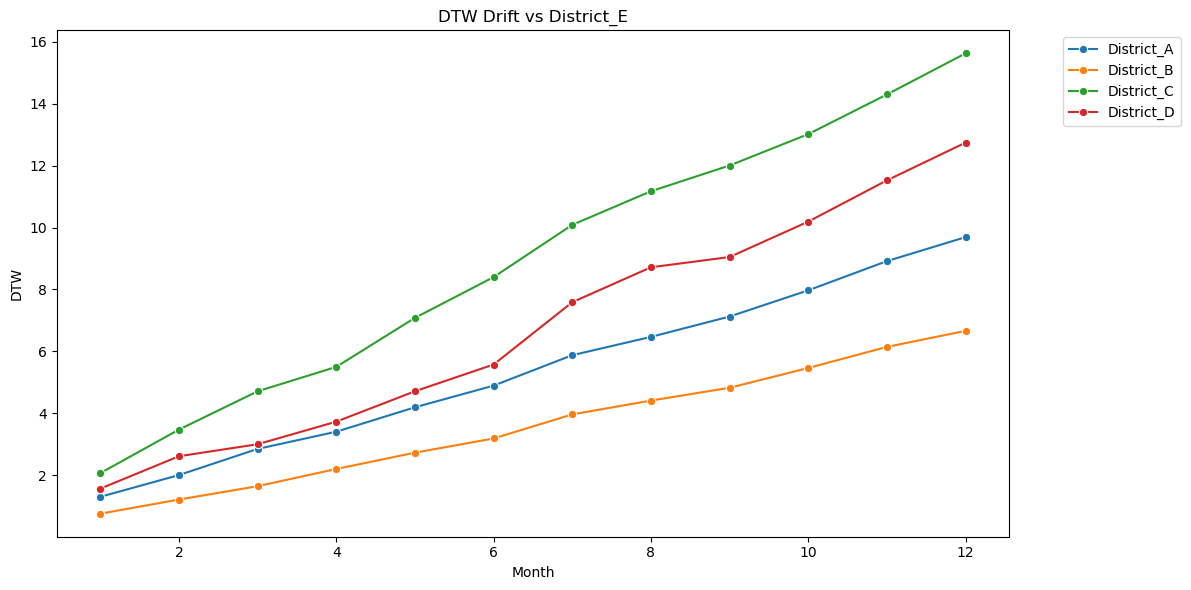

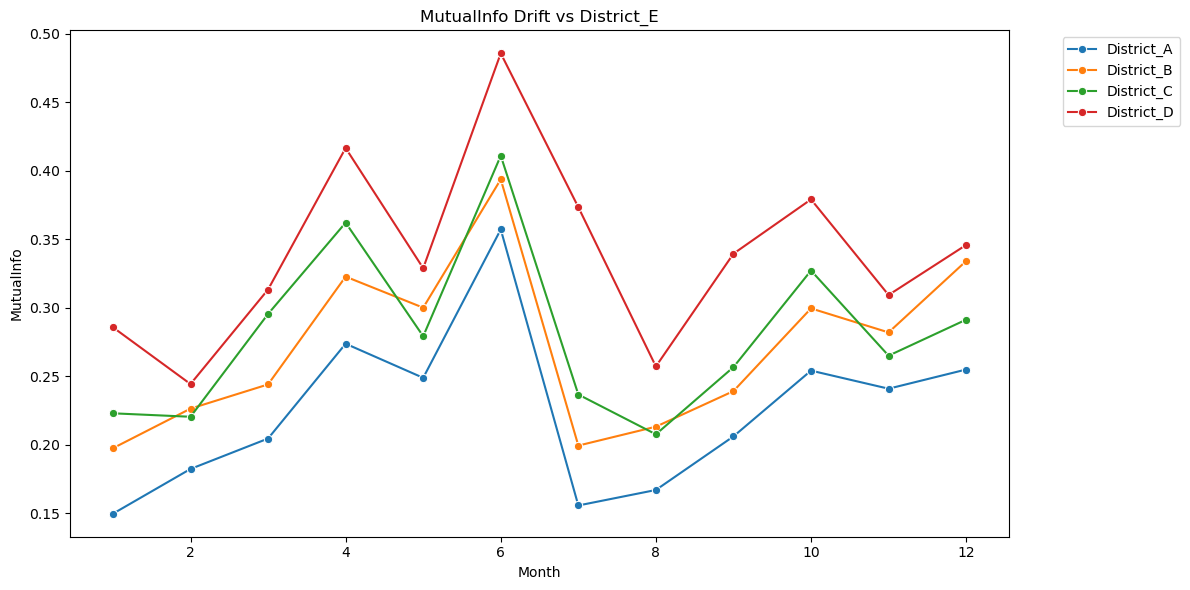

In [129]:
metrics = ["MMD", "Wasserstein", "Energy", "SubspaceAlignment", "DTW", "MutualInfo"]
df_results = pd.DataFrame(results)

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_results, x="month", y=metric, hue="other_client", marker="o")
    plt.title(f"{metric} Drift vs {target_client}")
    plt.xlabel("Month")
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

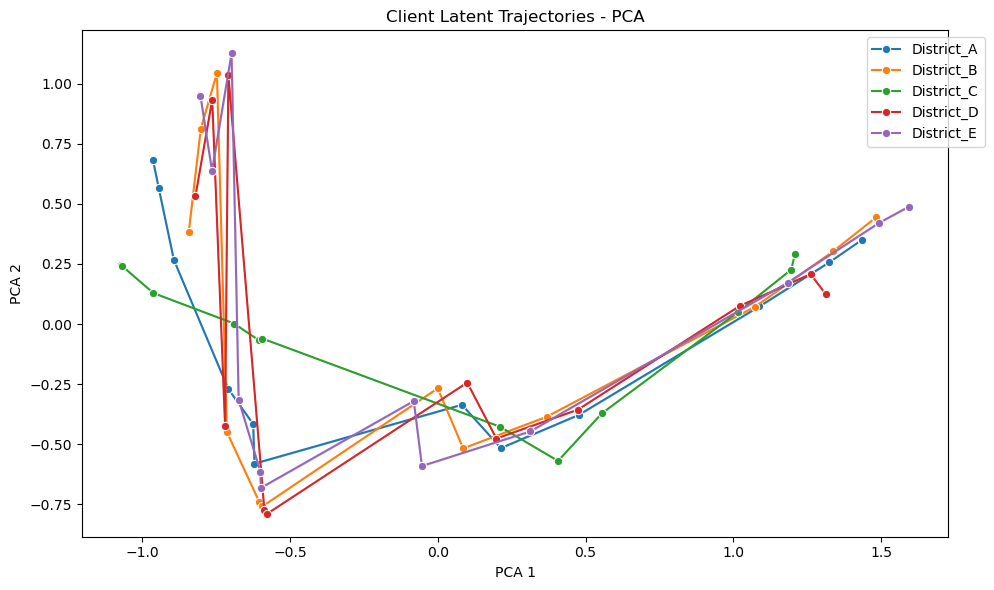

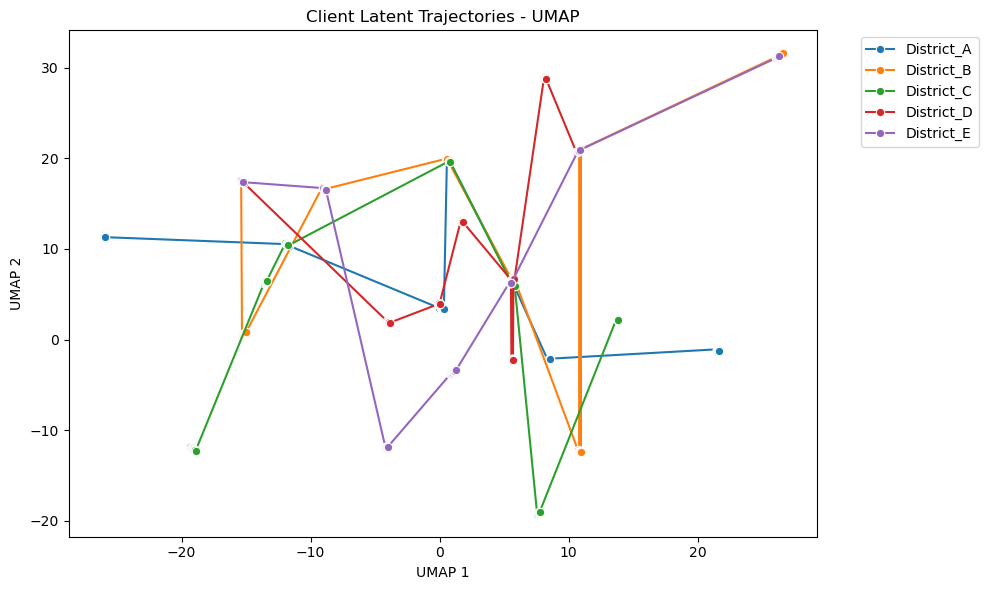

In [133]:
# Expand latent vector
df_traj = pd.DataFrame(client_monthly_embeddings)
df_traj_features = pd.DataFrame(df_traj["x"].tolist())
df_traj = pd.concat([df_traj.drop(columns="x"), df_traj_features], axis=1)
df_traj.columns = ['client_id', 'month'] + features

X_latent = df_traj[features].values
df_traj[["pca_x", "pca_y"]] = pca_model.fit_transform(X_latent)
df_traj[["umap_x", "umap_y"]] = umap_model.fit_transform(X_latent)


# PCA Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_traj, x="pca_x", y="pca_y", hue="client_id", marker="o", palette="tab10")
plt.title("Client Latent Trajectories - PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# UMAP Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_traj, x="umap_x", y="umap_y", hue="client_id", marker="o", palette="tab10")
plt.title("Client Latent Trajectories - UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

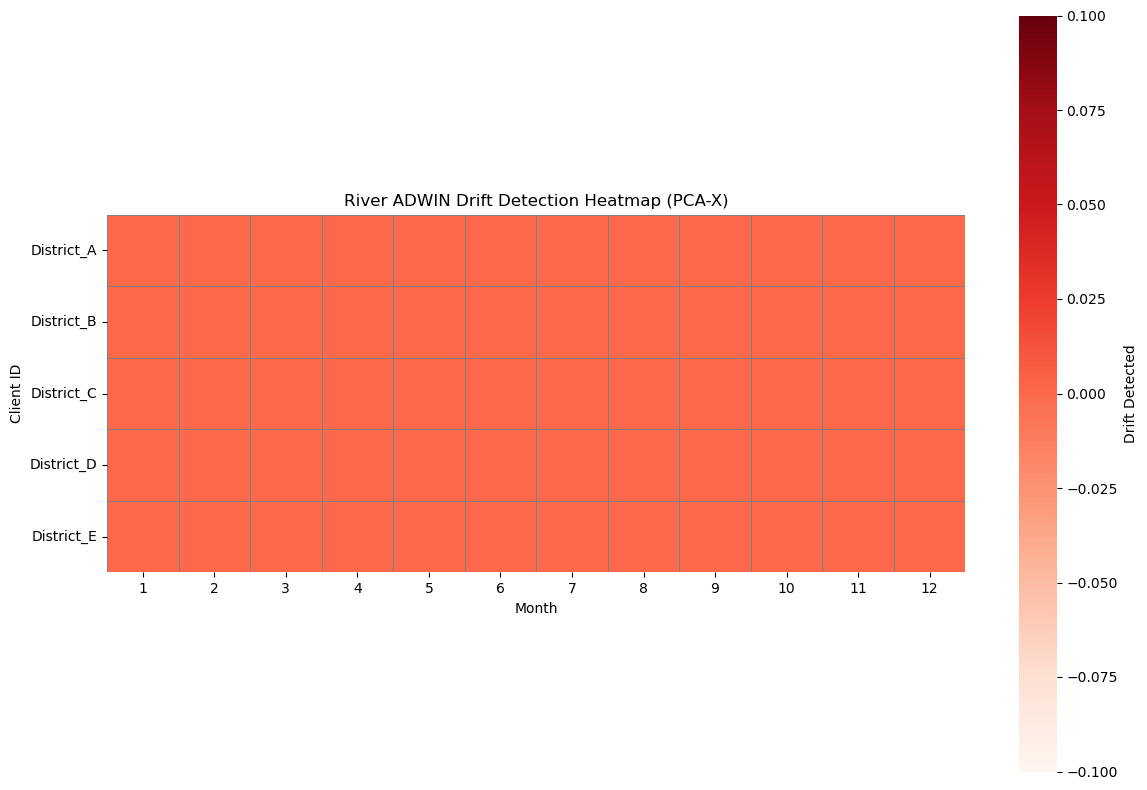

In [145]:
from river.drift import ADWIN
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

clients = df_traj["client_id"].unique()
months = sorted(df_traj["month"].unique())

# Initialize drift matrix
drift_matrix = pd.DataFrame(index=clients, columns=months)

for client in clients:
    detector = ADWIN()
    client_data = df_traj[df_traj["client_id"] == client].sort_values("month")

    for _, row in client_data.iterrows():
        val = row["pca_x"]  # or pca_y, umap_x, etc.
        detector.update(val)
        drift = int(detector.drift_detected)  # ‚úÖ River's correct attribute
        drift_matrix.loc[client, row["month"]] = drift

drift_matrix.fillna(0, inplace=True)
drift_matrix = drift_matrix.astype(int)


plt.figure(figsize=(12, 8))
sns.heatmap(drift_matrix, cmap="Reds", cbar_kws={"label": "Drift Detected"}, linewidths=0.5, linecolor='gray', square=True)
plt.title("River ADWIN Drift Detection Heatmap (PCA-X)")
plt.xlabel("Month")
plt.ylabel("Client ID")
plt.tight_layout()
plt.show()


In [149]:
from river.drift import ADWIN, EDDM, PageHinkley, HDDM_W
import pandas as pd
import numpy as np

def get_drift_detector(name):
    """Factory function for River drift detectors."""
    detectors = {
        "adwin": ADWIN,
        "eddm": EDDM,
        "pagehinkley": PageHinkley,
        "hddm": HDDM_W
    }
    return detectors[name.lower()]()

def detect_client_drift(
    df,
    target_client,
    feature_cols,
    detector_type="adwin"
):
    """
    Detects drift month-by-month for a target client compared to all others,
    using a specified drift detector and multiple dimensions.
    
    Parameters:
    - df: DataFrame with columns ['client_id', 'month', ...feature_cols]
    - target_client: ID of the target client
    - feature_cols: List of columns to use (latent/PCA/UMAP)
    - detector_type: Drift detector ('adwin', 'eddm', 'pagehinkley', 'hddm')

    Returns:
    - pd.Series with drift signal per month
    """
    df = df.copy()
    months = sorted(df["month"].unique())
    drift_series = []

    detector = get_drift_detector(detector_type)

    for month in months:
        df_month = df[df["month"] == month]
        target_rows = df_month[df_month["client_id"] == target_client]
        other_rows = df_month[df_month["client_id"] != target_client]

        # Mean over multiple samples for stability
        target_mean = target_rows[feature_cols].mean().values

        # Compare with all other clients (average difference)
        drift_input = 0
        count = 0
        for _, row in other_rows.iterrows():
            other_vector = row[feature_cols].values
            # Compute vector difference magnitude
            diff = np.linalg.norm(target_mean - other_vector)
            detector.update(diff)
            count += 1

        drift = int(detector.drift_detected) if count > 0 else 0
        drift_series.append((month, drift))

    return pd.Series({m: d for m, d in drift_series}, name=target_client)


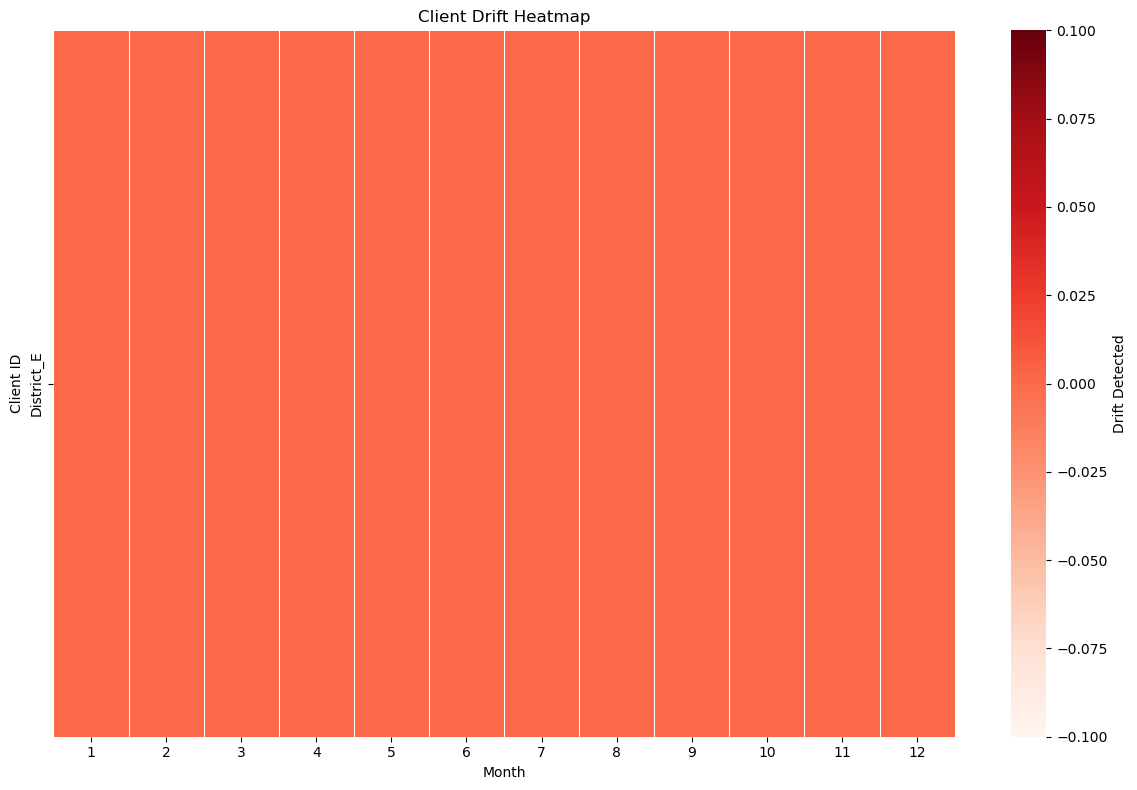

In [157]:
df_pca = client_data.copy()

client_id = "District_E"
feature_columns = ["pca_x", "pca_y"]  # or x_0 to x_39

drift = detect_client_drift(
    df=df_pca,
    target_client=client_id,
    feature_cols=feature_columns,
    detector_type="eddm"
)

all_clients = df_pca["client_id"].unique()
drift_all = pd.DataFrame()

for client in all_clients:
    drift_all[client] = detect_client_drift(
        df=df_pca,
        target_client=client,
        feature_cols=feature_columns,
        detector_type="adwin"  # can loop over detector types too
    )

# Transpose for heatmap
drift_all = drift_all.T.fillna(0).astype(int)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(drift_all, cmap="Reds", cbar_kws={"label": "Drift Detected"}, linewidths=0.5)
plt.title("Client Drift Heatmap")
plt.xlabel("Month")
plt.ylabel("Client ID")
plt.tight_layout()
plt.show()


In [175]:
import numpy as np
import pandas as pd
from river.drift import ADWIN, EDDM, PageHinkley, HDDM_W

def get_drift_detector(name):
    detectors = {
        "adwin": ADWIN,
        "eddm": EDDM,
        "pagehinkley": PageHinkley,
        "hddm": HDDM_W
    }
    return detectors[name.lower()]()

def compute_drift_intensity(
    df,
    target_client,
    feature_cols,
    detector_type="adwin",
    normalize=True
):
    """
    Computes drift intensity (mean distance from others) and optionally drift detection signals.
    """
    df = df.copy()
    months = sorted(df["month"].unique())
    results = []
    detector = get_drift_detector(detector_type) if detector_type else None

    for month in months:
        df_month = df[df["month"] == month]
        target_rows = df_month[df_month["client_id"] == target_client]
        other_rows = df_month[df_month["client_id"] != target_client]

        if len(target_rows) == 0 or len(other_rows) == 0:
            # Skipping this month due to missing data
            continue

        target_mean = target_rows[feature_cols].mean().values

        distances = []
        for _, row in other_rows.iterrows():
            other_vector = row[feature_cols].values
            dist = np.linalg.norm(target_mean - other_vector)
            distances.append(dist)
            if detector:
                detector.update(dist)

        intensity = np.mean(distances)
        drift_flag = int(detector.drift_detected) if detector else None

        results.append({
            "month": month,
            "intensity": intensity,
            "drift": drift_flag
        })

    if not results:
        print(f"[WARN] No data available to compute drift for client '{target_client}'.")
        return pd.DataFrame(columns=["month", "intensity", "drift"])

    df_result = pd.DataFrame(results)
    df_result.set_index("month", inplace=True)

    if normalize and not df_result["intensity"].isnull().all():
        df_result["intensity"] = (
            (df_result["intensity"] - df_result["intensity"].min()) /
            (df_result["intensity"].max() - df_result["intensity"].min() + 1e-8)
        )

    return df_result


In [177]:
client = "District_E"
features = [f"x_{i}" for i in range(40)]  # or PCA/UMAP components
df_pca = client_data.copy()

intensity_df = compute_drift_intensity(
    df=df_pca,  # your full latent/PCA DataFrame
    target_client=client,
    feature_cols=features,
    detector_type="pagehinkley",  # optional
    normalize=True
)


[WARN] No data available to compute drift for client 'District_E'.


In [179]:
intensity_df

Empty DataFrame
Columns: [month, intensity, drift]
Index: []

prompt:
Im working with representations of temporal series - which are basically the feature extraction on the latent space of an autoencoder. The context is to detect drift in the federated learning context, in a macrocontext of leakage detection - so the data is time series.

So, instead of using data, im aiming to use these latent representations to assert similarities or changes between clients. I'm using contrastive learning to make m model put diferent months observations in diferent regions on the latent space.

I dont want to use only distances to measure and compare changes/similarities between clients, can ou please suggest some strategies to assert that?

Response:
üîÑ 1. Distributional Similarity Metrics (Beyond Distance)
Instead of Euclidean or cosine distances, measure how entire distributions in latent space shift over time:

Maximum Mean Discrepancy (MMD): A kernel-based method to compare two distributions in latent space. Useful to detect subtle shifts.

Wasserstein Distance (Earth Mover‚Äôs Distance): Measures the effort to transform one distribution into another. Good for temporal shift.

Energy Distance: Another distribution-based metric that captures divergence in samples.

Kernel Two-Sample Test (e.g., HSIC): To statistically test if two samples (e.g., client A's latent representation from month 1 and month 2) come from the same distribution.

üß† 2. Representation Clustering and Topology
Capture structural or geometric patterns in the latent space:

Persistent Homology / Topological Data Analysis (TDA): Use persistence diagrams to measure topological changes in the manifold structure of embeddings.

Spectral Clustering on Latent Graphs: Create similarity graphs of representations and track changes in graph eigenvectors (Laplacian spectrum) over time.

Density-based Clustering (e.g., DBSCAN) and Cluster Drift: Track number and shape of clusters in latent space across months/clients.

üß¨ 3. Manifold/Embedding Alignment Techniques
Compare latent spaces geometrically over time, without relying on direct distances:

Procrustes Analysis: Align embeddings from two time steps and measure the transformation required.

Canonical Correlation Analysis (CCA): Measure the linear relationship between two sets of latent variables (month t and t+1).

Geodesic Flow Kernel / Subspace Alignment: Used in domain adaptation; track how subspaces evolve between clients/timesteps.

üß™ 4. Contrastive Representation Drift Probes
Given you're using contrastive learning, you can extend that idea to probe the drift directly:

Train a contrastive classifier to distinguish latent representations from two months. If it performs well, they are separable (drift has occurred).

Hard negative mining: If previously similar clients start appearing as hard negatives, it can indicate drift.

Class separability metrics (e.g., Fisher criterion, SVM margin width) in latent space across time.

üîç 5. Mutual Information and Entropy Measures
Capture shared information or uncertainty:

Mutual Information (MI) between representations of different months/clients.

Conditional Entropy: How predictable is month t+1 given month t representations?

Information Bottleneck (IB): How much information about the client/time label is retained in latent space?

üß≠ 6. Temporal Dynamics Modeling
Model the latent representation trajectory over time:

Trajectory Embedding Comparison: Encode client evolution over time as sequences and compare them via DTW (Dynamic Time Warping), or RNN embeddings.

Autoregressive Models: Fit an AR or RNN model to latent vectors. Changes in residuals or coefficients can signal drift.

Latent ODEs: Capture continuous-time dynamics of latent representations.

üìä 7. Statistical Testing and Outlier Detection
Change Point Detection Algorithms (e.g., RuLSIF, Bayesian Online Change Point Detection) applied on latent representations per client.

Anomaly scores (Isolation Forests, One-Class SVMs) trained on earlier latent space periods and applied to newer ones.

Permutation-based drift tests, e.g., apply permutation importance in a classifier trained to discriminate client/time labels.

Integration Strategy (Macrocontext-aware)
Since you're in a federated learning + leakage detection context:

Use cross-client metrics to capture common or divergent patterns (e.g., align or cluster client trajectories).

Consider federated aggregation of latent drift scores for global drift awareness without centralizing raw data.

Monitor temporal consistency of latent features within and across clients, possibly using privacy-preserving sketching methods.


Data:
Labels represent months, client_id the clients and the remaining are features of the latent space, such as

	label	client_id	x_0	x_1	x_2	x_3	x_4	x_5	x_6	x_7	...	x_30	x_31	x_32	x_33	x_34	x_35	x_36	x_37	x_38	x_39
0	1	District_A	0.346425	0.528547	0.345281	0.252769	0.271071	0.525118	0.952367	0.338785	...	0.885777	0.921251	0.812938	0.327208	0.960554	0.727612	0.189739	0.134118	0.666391	0.730167
1	1	District_A	0.922042	0.651472	0.149660	0.476432	0.346260	0.640628	0.950953	0.714316	...	0.835812	0.899418	0.731884	0.419002	0.954092	0.717899	0.116916	0.096327	0.666886	0.819726

Can you please help me check the diffs/similarities between clients over the months (labels), using:

1. Maximum Mean Discrepancy (MMD) and Wasserstein Distance and Energy Distance

2. Spectral Clustering on Latent Graphs and Density-based Clustering (e.g., DBSCAN)

3. Geodesic Flow Kernel / Subspace Alignment

4. Mutual Information (MI), Conditional Entropy and Information Bottleneck (IB)

5. Trajectory Embedding Comparison: Encode client evolution over time as sequences and compare them via DTW (Dynamic Time Warping)

Can you please help me with that?